In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
from decimal import Decimal

In [2]:
#by_60211642
data = pd.read_csv("./코로나바이러스감염증-19_확진환자_발생현황_221126.csv", header = 0)
data.tail(10)

,일자,계(명),국내발생(명),해외유입(명),사망(명),Unnamed: 5,열2,열3,열4,열5,Unnamed: 10,Unnamed: 11
1033,2022.11.18,"49,399","49,333",66,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1034,2022.11.19,"50,568","50,518",50,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,2022.11.20,"45,998","45,940",58,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1036,2022.11.21,"23,077","23,016",61,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,2022.11.22,"72,860","72,779",81,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,2022.11.23,"70,306","70,237",69,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,2022.11.24,"59,082","59,027",55,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1040,2022.11.25,"53,698","53,659",39,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1041,2022.11.26,"52,788","52,726",62,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1042,누적(명),"26,890,488","26,819,311","71,177","30,330",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_covid = data.loc[:,['일자','계(명)','사망(명)']][:1042]
df_accumulate = data.loc[:,['일자','계(명)','사망(명)']][1042:1043] 

df_covid.isna().sum()

df_covid = df_covid.replace("-", 0).set_index('일자')


In [4]:
#누적 확진자 수 구하는 코드
df_covid["누적 확진자 수"] = df_covid["계(명)"]
def cumulative_number(i):
    if i == 0:
        df_covid["누적 확진자 수"][0] = int(df_covid["계(명)"][0])
    else:
        if type(df_covid["계(명)"][i]) != int :
            p = df_covid["계(명)"][i].split(",")
            str_confirmed = ""
            num_confirmed = 0
            for j in range(len(p)):
                str_confirmed+=p[j]
            df_covid["계(명)"][i] = int(str_confirmed)
            
        df_covid["누적 확진자 수"][i] = int(df_covid["누적 확진자 수"][i-1]) + df_covid["계(명)"][i]

for i in range(len(df_covid)):
    cumulative_number(i)

In [5]:
#감염률 구하는 코드
df_covid["감염률"] = df_covid["계(명)"]
def infection_rate(i):
    rok_pop = 51628117
    if i == 0:
        df_covid["감염률"][0] = int(df_covid["계(명)"][0])/rok_pop
    else:
        #분모 (전체 국민 - 당일의 누적 확진자 수)
        denominator = (rok_pop - df_covid["누적 확진자 수"][i-1])
        #분자 (당일의 확진자 수)
        numerator = df_covid["계(명)"][i]
        p_infection = numerator/denominator
        df_covid["감염률"][i] = p_infection
            
    
for i in range(len(df_covid)):
    infection_rate(i)

In [6]:
#치명률 구하는 코드
df_covid["치명률"] = df_covid["사망(명)"]
def death_rate(i):
    if i == 0:
        df_covid["치명률"][0] = 0
    else:
        #분모 (당일 사망자 수)
        #분자 (누적 확진자 수)
        p_lethality = Decimal(df_covid["사망(명)"][i])/Decimal(df_covid["누적 확진자 수"][i])
        df_covid["치명률"][i] = p_lethality
            
    
for i in range(len(df_covid)):
    death_rate(i)


In [7]:
#우세종에 따른 데이터 구간 나누기
df_covid_etc = df_covid.loc['2020.1.20':"2021.7.31"]
df_covid_delta = df_covid.loc["2021.7.31":"2022.1.24"]
df_covid_omi = df_covid.loc["2022.1.24":]

[1. 감염률 데이터 분석]
[정규성 검증]
Shapiro Test-statistics : 0.8386266827583313, p-value : 2.2416309348083722e-23
Shapiro Test-statistics : 0.8340774774551392, p-value : 5.873756342422709e-13
Shapiro Test-statistics : 0.8049131631851196, p-value : 6.438464212370943e-19

[등분산 검증]
Bartlett Test-statistics : 6661.2950266328, p-value : 0.0


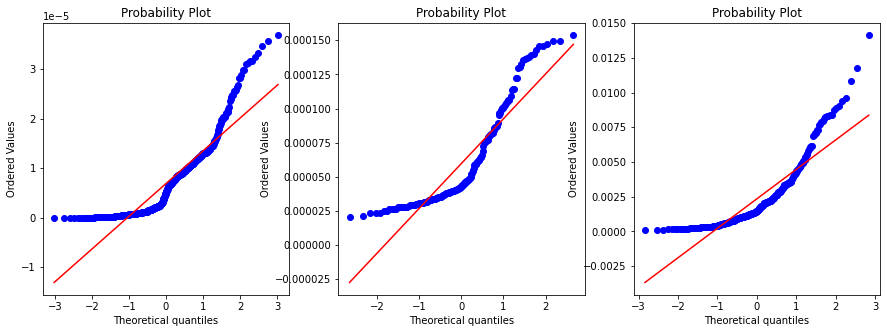

In [8]:
#1 감염률 데이터 분석 
print("[1. 감염률 데이터 분석]")
#타입변환
df_covid_etc = df_covid_etc.astype({'감염률' : 'float'})
df_covid_delta = df_covid_delta.astype({'감염률' : 'float'})
df_covid_omi = df_covid_omi.astype({'감염률' : 'float'})

#정규성 검증
print("[정규성 검증]")
test_stat, p_val = stats.shapiro(df_covid_etc["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_delta["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_omi["감염률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

#등분산 검증
print("[등분산 검증]")
test_stat, p_val = stats.bartlett(df_covid_etc["감염률"],df_covid_delta["감염률"],df_covid_omi["감염률"])
print("Bartlett Test-statistics : {}, p-value : {}".format(test_stat, p_val))
# test_stat, p_val = stats.fligner(df_covid_etc["계(명)"],df_covid_delta["계(명)"],df_covid_omi["계(명)"])
# print("Fligner Test-statistics : {}, p-value : {}".format(test_stat, p_val))
# test_stat, p_val = stats.levene(df_covid_etc["계(명)"],df_covid_delta["계(명)"],df_covid_omi["계(명)"])
# print("Levene Test-statistics : {}, p-value : {}".format(test_stat, p_val))

#Q-Q plot
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1) 
plt1 = stats.probplot(df_covid_etc["감염률"],dist=stats.norm, plot=plt)
ax2 = fig.add_subplot(1,3,2) 
plt2 = stats.probplot(df_covid_delta["감염률"],dist=stats.norm, plot=plt)
ax3 = fig.add_subplot(1,3,3) 
plt3 = stats.probplot(df_covid_omi["감염률"],dist=stats.norm, plot=plt)


In [9]:
#2 치명률 데이터 분석 
print("[1. 치명률 데이터 분석]")
# #타입변환
# df_covid_etc = df_covid_etc.astype({'치명률' : 'float'})
# df_covid_delta = df_covid_delta.astype({'치명률' : 'float'})
# df_covid_omi = df_covid_omi.astype({'감염률' : 'float'})

#정규성 검증
print("[정규성 검증]")
test_stat, p_val = stats.shapiro(df_covid_etc["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_delta["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
test_stat, p_val = stats.shapiro(df_covid_omi["치명률"])
print("Shapiro Test-statistics : {}, p-value : {}".format(test_stat, p_val))
print()

#등분산 검증
print("[등분산 검증]")
test_stat, p_val = stats.bartlett(df_covid_etc["치명률"],df_covid_delta["치명률"],df_covid_omi["치명률"])
print("Bartlett Test-statistics : {}, p-value : {}".format(test_stat, p_val))
# test_stat, p_val = stats.fligner(df_covid_etc["계(명)"],df_covid_delta["계(명)"],df_covid_omi["계(명)"])
# print("Fligner Test-statistics : {}, p-value : {}".format(test_stat, p_val))
# test_stat, p_val = stats.levene(df_covid_etc["계(명)"],df_covid_delta["계(명)"],df_covid_omi["계(명)"])
# print("Levene Test-statistics : {}, p-value : {}".format(test_stat, p_val))

#Q-Q plot
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1) 
plt1 = stats.probplot(df_covid_etc["치명률"],dist=stats.norm, plot=plt)
ax2 = fig.add_subplot(1,3,2) 
plt2 = stats.probplot(df_covid_delta["치명률"],dist=stats.norm, plot=plt)
ax3 = fig.add_subplot(1,3,3) 
plt3 = stats.probplot(df_covid_omi["치명률"],dist=stats.norm, plot=plt)

[1. 치명률 데이터 분석]
[정규성 검증]
Shapiro Test-statistics : 0.18542635440826416, p-value : 1.2051166793193427e-43
Shapiro Test-statistics : 0.8876866698265076, p-value : 2.5538296477556344e-10
Shapiro Test-statistics : 0.6956334114074707, p-value : 3.3587356005143987e-23

[등분산 검증]


TypeError: unsupported operand type(s) for -: 'float' and 'decimal.Decimal'

(문제발생)
치명률이 너무 작아서 int 타입으로 변환시 전부 0.0으로 보인다
-> Decimal 타입을 사용할 경우 매우 작은 소수 형태로 나타낼 수 있다
-> 하지만 Decimal 타입일 경우 등분산 검증을 위한 bartlett test가 돌아가지 않는다 

따라서, 치명률을 구하는 방법에 수정이 필요하다